# HW №2 от Бондаренко Алексея (bondaleksey@gmail.com)

Цель данного ноутбука на тестовом наборе данных провести:
- сравнение методов кластеризации k-means, hierarhical и DBSCAN
- осуществить визуализацию разбиения на кластеры, основываясь на методы сжатия признакового пространства PCA, tSNE, UMAP 


Основные пункты задания: 

*   Разведывательный анализ (EDA) и предварительная обработка данных
*   Кластеризация и визуализация разбиений 
*   Интерпретация результатов

Мотивация: 
Сегментация клиентов (в данном случае - банка). Крайне полезная операция, которая позволяет вам лучше познакомится со своей аудиторией, понять, на какие группы она делится и чем они характеризуются.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
from sklearn.preprocessing import StandardScaler

from sklearn import metrics

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import DBSCAN

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

# 1 Разведывательный анализ и предварительная обработка данных

В работе используются известный датасет [клиентов немецкого банка](https://www.kaggle.com/uciml/german-credit) размещенный на Kaggle. Чтобы не плодить лишние сущности папка data включена в файл gitignore. 




In [2]:
# from os.path import exists
# filepath = 'data_cl/'
# if exists(filepath):
#     print(f"filepath {filepath} existing")
    

## 1.1 Получим первое впечатление о данных 

In [3]:
data = pd.read_csv('data_cl/archive.zip', compression='zip', header=0, sep=',', quotechar='"',index_col=0)

In [4]:
data.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
dtypes: int64(4), object(5)
memory usage: 78.1+ KB


In [6]:
data_short = data.dropna()
data_short.info()   

<class 'pandas.core.frame.DataFrame'>
Int64Index: 522 entries, 1 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               522 non-null    int64 
 1   Sex               522 non-null    object
 2   Job               522 non-null    int64 
 3   Housing           522 non-null    object
 4   Saving accounts   522 non-null    object
 5   Checking account  522 non-null    object
 6   Credit amount     522 non-null    int64 
 7   Duration          522 non-null    int64 
 8   Purpose           522 non-null    object
dtypes: int64(4), object(5)
memory usage: 40.8+ KB


In [7]:
data_full = data.fillna('na')
data_full.info()            

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   1000 non-null   object
 5   Checking account  1000 non-null   object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
dtypes: int64(4), object(5)
memory usage: 78.1+ KB


In [8]:
data_short.describe()

,Age,Job,Credit amount,Duration
count,522.000000,522.000000,522.000000,522.000000
mean,34.888889,1.875479,3278.745211,21.339080
std,11.787918,0.682811,2929.155177,12.474079
min,19.000000,0.000000,276.000000,6.000000
25%,26.000000,2.000000,1297.500000,12.000000
50%,31.500000,2.000000,2326.500000,18.000000
75%,41.000000,2.000000,3971.250000,26.750000
max,75.000000,3.000000,18424.000000,72.000000


In [9]:
data_full.describe()

,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000
std,11.375469,0.653614,2822.736876,12.058814
min,19.000000,0.000000,250.000000,4.000000
25%,27.000000,2.000000,1365.500000,12.000000
50%,33.000000,2.000000,2319.500000,18.000000
75%,42.000000,2.000000,3972.250000,24.000000
max,75.000000,3.000000,18424.000000,72.000000


## 1.2 Проведем разведывательный анализ данных

In [10]:
def EDA(data):
    cols = data_full.columns
    print('Printing figures for columns:\n',cols)
    for item in cols:
        dt = data[item].dtype          
        if dt == 'int64'or dt == 'int32':        
            ax = data[item].plot(kind = 'hist', bins = 20)
            ax.set_xlabel(item)
            plt.show()
        elif dt == 'object':
            ax = data[item].value_counts().plot(kind = 'bar')
            ax.set_xlabel(item)
            plt.show()
        else:
            print(f'ooops, have problems with {item}')


Printing figures for columns:
 Index(['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account',
       'Credit amount', 'Duration', 'Purpose'],
      dtype='object')


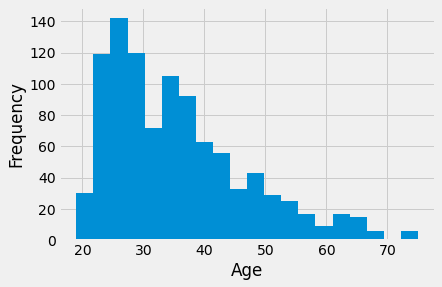

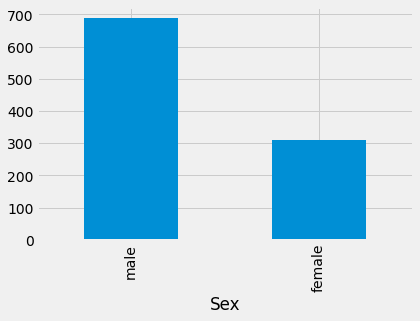

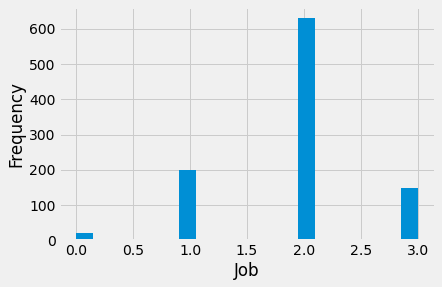

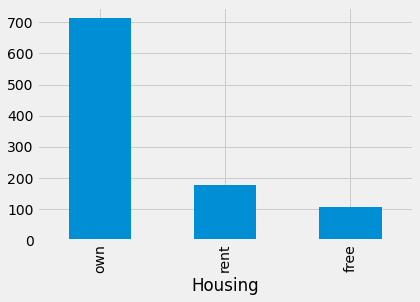

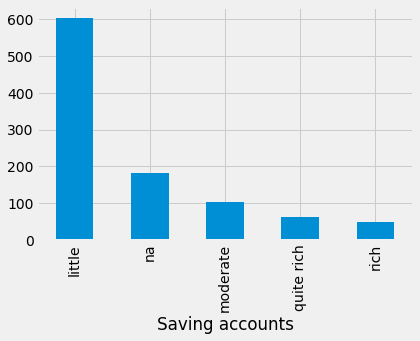

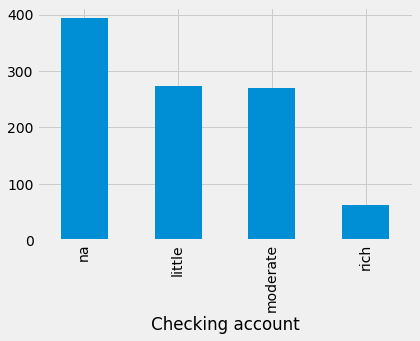

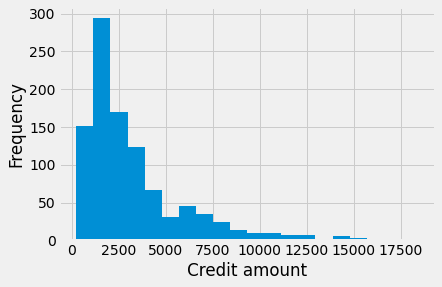

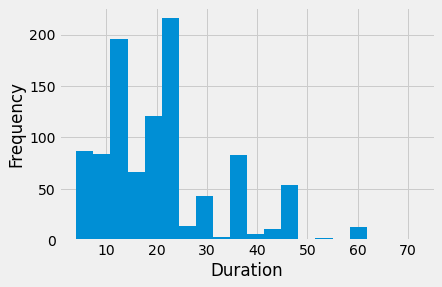

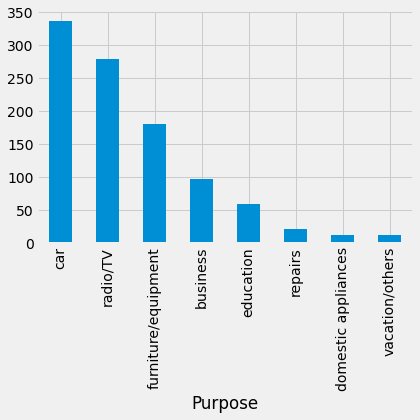

In [11]:
EDA(data_full)


## 1.3 Преобразуем все признаки в числовые

In [12]:
def preproseccing(data):
    categorical_cols = [x for x in data.columns if data[x].dtype == 'object']    
    dummies = pd.get_dummies(data[categorical_cols], drop_first=True)
    df = pd.concat([data.drop(categorical_cols,axis=1), dummies],axis=1)    
    return df

In [13]:
data_full_floats = preproseccing(data_full)
data_full_floats.head()

,Age,Job,Credit amount,Duration,Sex_male,Housing_own,Housing_rent,Saving accounts_moderate,Saving accounts_na,Saving accounts_quite rich,...,Checking account_moderate,Checking account_na,Checking account_rich,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
0,67,2,1169,6,1,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,22,2,5951,48,0,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2,49,1,2096,12,1,1,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
3,45,2,7882,42,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,53,2,4870,24,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [14]:
data_short_floats = preproseccing(data_short)
data_short_floats.head()

,Age,Job,Credit amount,Duration,Sex_male,Housing_own,Housing_rent,Saving accounts_moderate,Saving accounts_quite rich,Saving accounts_rich,Checking account_moderate,Checking account_rich,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
1,22,2,5951,48,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0
3,45,2,7882,42,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,53,2,4870,24,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
7,35,3,6948,36,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0
9,28,3,5234,30,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0


## 1.4 Приведем все даные к одному масштабу

При нахождении расстояния предполагается, что каждый признак имеет "одинаковый вес" = расстояния по разным признакам вносят одинаковый вклад в общее расстояние. А так как единицы измерения физического значения признака измеряются в разных диапазонах, то и веса этих признаком будут разные. Поэтому StandardScaler() необходимая операция при кластеризации.

In [15]:
scaler = StandardScaler()
X_full = scaler.fit_transform(data_full_floats)
X_short = scaler.fit_transform(data_short_floats)

In [16]:
print(type(X_full))
print('X_full: ',X_full.shape)
print(X_full[:6,:6])
print('X_short: ',X_short.shape)
print(X_short[:6,:6])

<class 'numpy.ndarray'>
X_full:  (1000, 21)
[[ 2.76645648  0.14694918 -0.74513141 -1.23647786  0.67028006  0.63444822]
 [-1.19140394  0.14694918  0.94981679  2.24819436 -1.49191369  0.63444822]
 [ 1.18331231 -1.38377145 -0.41656241 -0.73866754  0.67028006  0.63444822]
 [ 0.8315025   0.14694918  1.63424694  1.75038404  0.67028006 -1.57617276]
 [ 1.53512213  0.14694918  0.5666635   0.25695309  0.67028006 -1.57617276]
 [-0.04802204 -1.38377145  2.05000901  1.25257373  0.67028006 -1.57617276]]
X_short:  (522, 19)
[[-1.09444711  0.18254035  0.9131705   2.13935578 -1.4516001   0.70406108]
 [ 0.85857489  0.18254035  1.57303731  1.65789696  0.68889496 -1.42033131]
 [ 1.53788689  0.18254035  0.54376811  0.21352053  0.68889496 -1.42033131]
 [ 0.00943489  1.64847973  1.25386818  1.17643815  0.68889496 -1.42033131]
 [-0.58496311  1.64847973  0.66815522  0.69497934  0.68889496  0.70406108]
 [-0.83970511  0.18254035 -0.67789105 -0.7493971  -1.4516001  -1.42033131]]


# 2 Моделирование
Рассмотрим 3 варианта кластеризации: K-means, hierarhical и DBSCAN.
Определять оптимальное число кластеров, будем методом локтя (Elbow) и методом силуэта (Silhouette)

## 2.1 Kmeans


In [17]:
def calculate_elbow_kmean(data):
    output_inertia = []
    output_range = list(range(1,25))
    for k in output_range:
        # print(k)
        kmeans = KMeans(n_clusters=k, init='k-means++')
        kmeans = kmeans.fit(data)        
        output_inertia.append(kmeans.inertia_)
    return {'range':output_range, 'inertia':output_inertia}

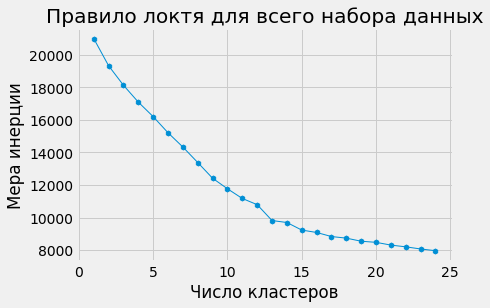

In [18]:
elbow_full = calculate_elbow_kmean(X_full)
plt.plot(elbow_full['range'],elbow_full['inertia'],marker='h',linewidth=1, markersize=5);
plt.xlabel('Число кластеров')
plt.ylabel('Мера инерции')
plt.title('Правило локтя для всего набора данных')
plt.show()

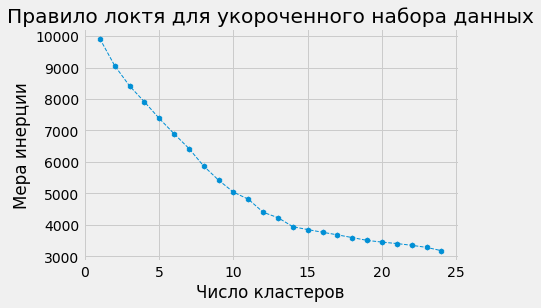

In [19]:
elbow_short = calculate_elbow_kmean(X_short)
plt.plot(elbow_short['range'],elbow_short['inertia'],marker='h',linestyle='dashed',linewidth=1, markersize=5);
plt.xlabel('Число кластеров')
plt.ylabel('Мера инерции')
plt.title('Правило локтя для укороченного набора данных')
plt.show()

In [20]:
print(max(data.shape))

1000


In [21]:
def silhouette(data):
    output_silhouette = []
    output_range = list(range(2,50))
    for k in output_range:
        labels = KMeans(n_clusters=k, init='k-means++', random_state=200).fit(data).labels_
        silhouette = metrics.silhouette_score(data, labels, metric='euclidean', sample_size=max(data.shape),random_state=200)
        output_silhouette.append(silhouette)
        # print(f"Silhouette score for k(clusters) = {k} is {silhouette}")
    return {'range':output_range, 'silhouette':output_silhouette}
        

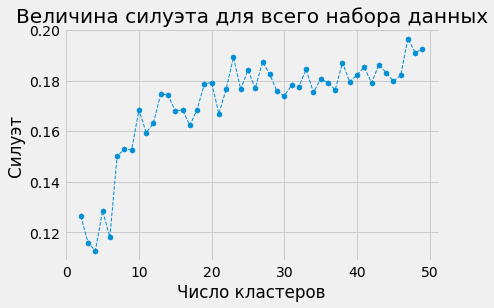

In [22]:
silh_full = silhouette(X_full)
plt.plot(silh_full['range'],silh_full['silhouette'],marker='h',linestyle='dashed',linewidth=1, markersize=5);
plt.xlabel('Число кластеров')
plt.ylabel('Силуэт')
plt.title('Величина силуэта для всего набора данных')
plt.show()

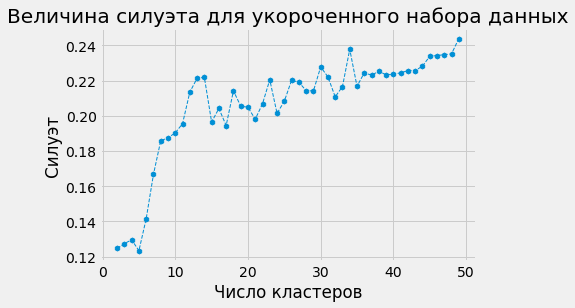

In [23]:
silh_short = silhouette(X_short)
plt.plot(silh_short['range'],silh_short['silhouette'],marker='h',linestyle='dashed',linewidth=1, markersize=5);
plt.xlabel('Число кластеров')
plt.ylabel('Силуэт')
plt.title('Величина силуэта для укороченного набора данных')
plt.show()

## 2.2 Hierarhical

In [24]:
# Was taken from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
#
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


In [25]:
X_full.shape

(1000, 21)

In [26]:
def plot_dendrograms(data):
    linkage=["ward" , "average", "complete", "single"]
    for link in linkage:
        model = AgglomerativeClustering(linkage=link, distance_threshold = 0, n_clusters=None)
        model.fit(data)
        plt.title(f"Дендограмма, linkage:{link}")
        plot_dendrogram(model, truncate_mode="level", p=4)
        plt.xlabel("Number of points in node.")
        plt.show()

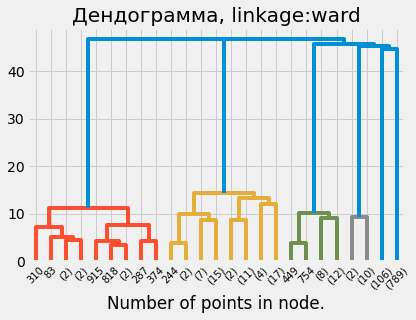

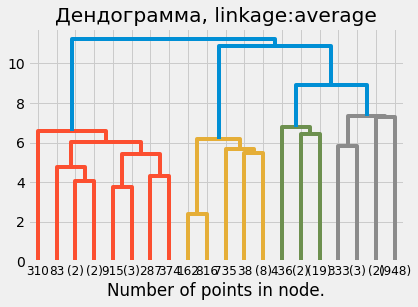

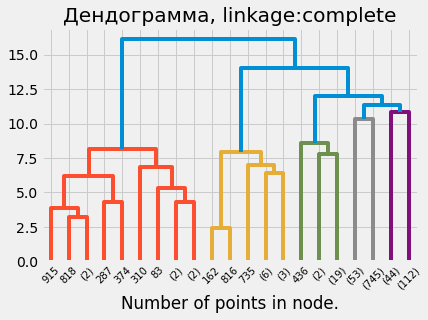

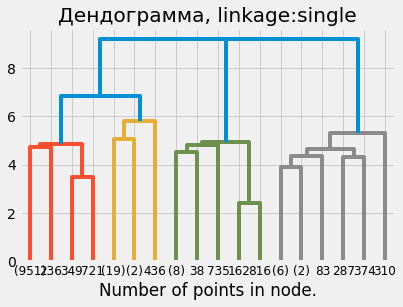

In [27]:
plot_dendrograms(X_full)

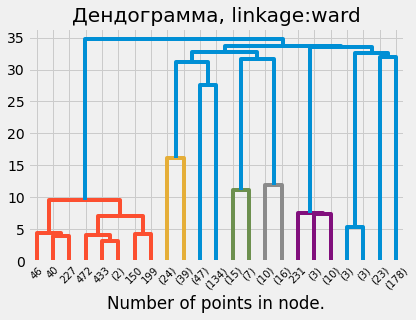

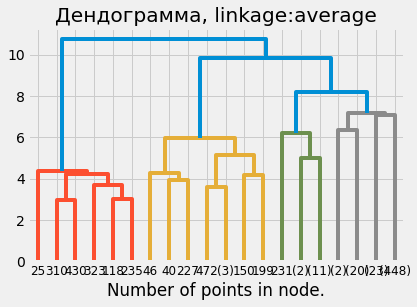

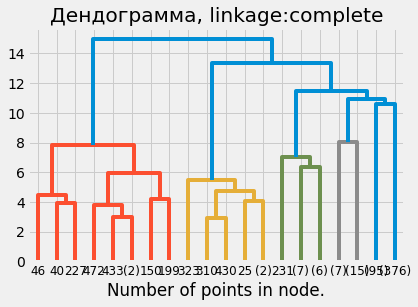

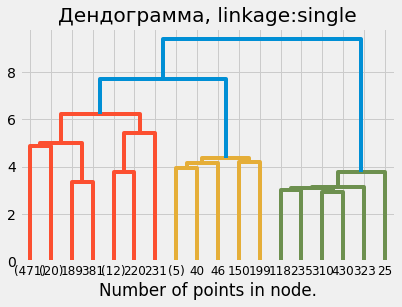

In [28]:
plot_dendrograms(X_short)

In [29]:
def use_hierarchical(data,link):
    eps_range = np.concatenate((np.linspace(1,15,100), np.linspace(15.1,50,50)))
    output = []
    for epsilon in eps_range:       
        labels = AgglomerativeClustering(linkage=link, distance_threshold = epsilon, n_clusters=None).fit_predict(data)
        n_clusters = len(set(labels))
        if n_clusters<2:
            continue
        result = {
            "epsilon":epsilon,
            "clusters":n_clusters,                        
            "Silhouette": metrics.silhouette_score(data, labels)           
        }
        # print(result)
        output.append(result)
    return output

In [30]:
def plot_df(data,name=""):
    cols = data.columns
    # print('Printing figures for columns:\n',cols)
    for item in cols:        
        ax = data[item].plot(kind = 'line')
        ax.set_title(name)
        ax.set_xlabel(item)
        plt.show()   

In [59]:
def full_hierarchical_search(data):
    linkage=["ward" , "average", "complete", "single"]
    for link in linkage:
        h_data = use_hierarchical(data,link)
        df_data = pd.DataFrame(h_data)
        df_data = df_data.set_index("epsilon")
        print(f"____________ Plot for {link} ____________")    
        plot_df(df_data,f"Hierarchical search with linkage: {link}")
        plot_df(df_data.iloc[-30:],f"Hierarchical search with linkage: {link}")
    

____________ Plot for ward ____________


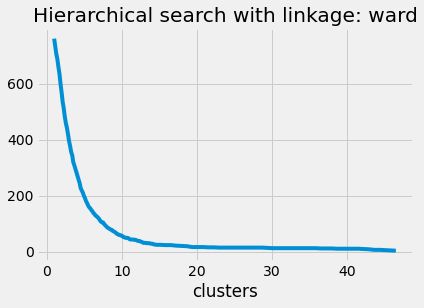

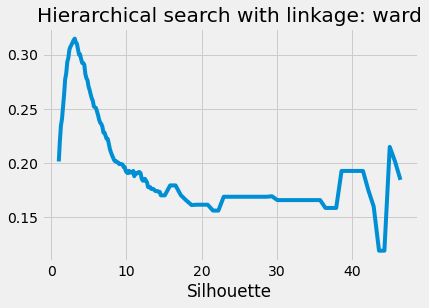

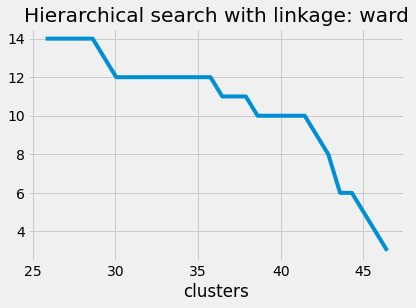

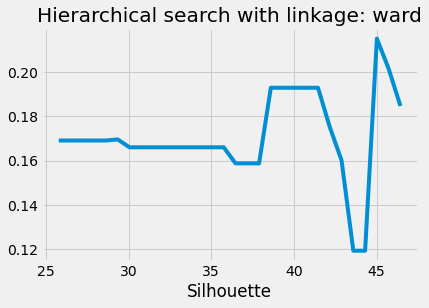

____________ Plot for average ____________


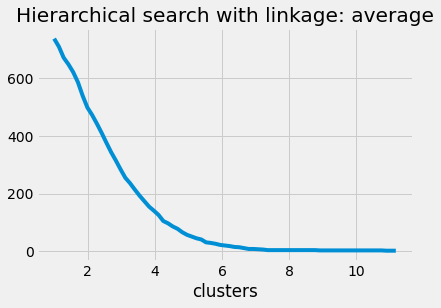

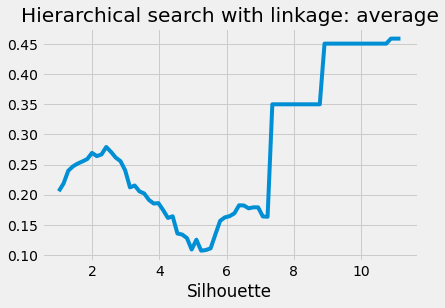

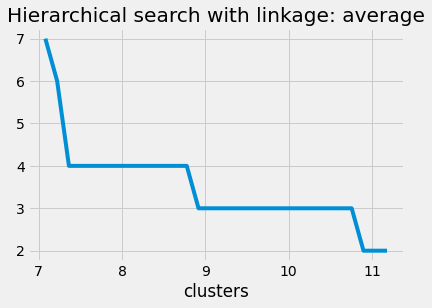

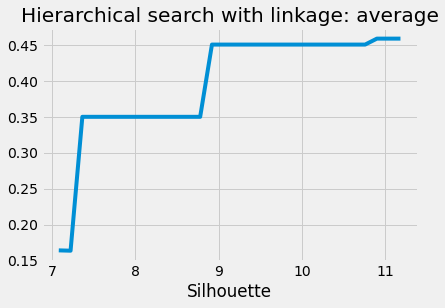

____________ Plot for complete ____________


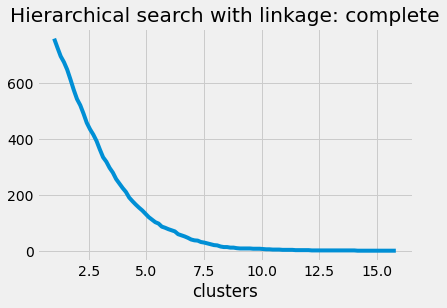

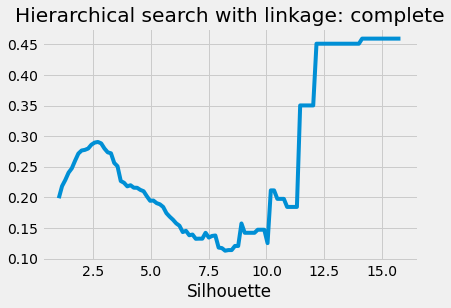

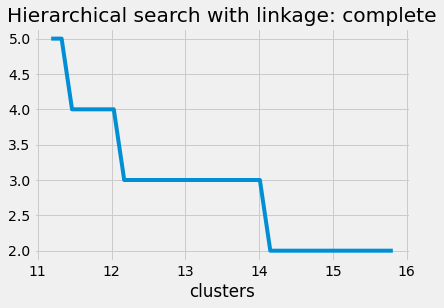

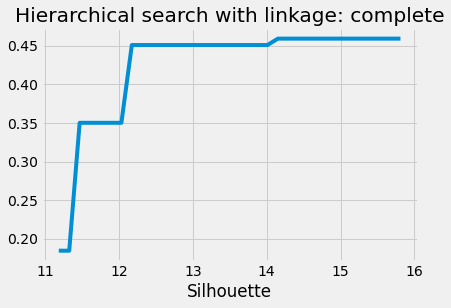

____________ Plot for single ____________


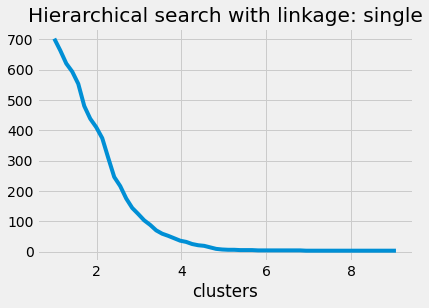

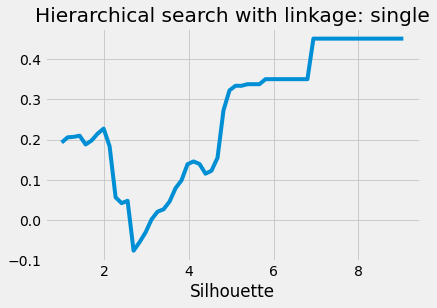

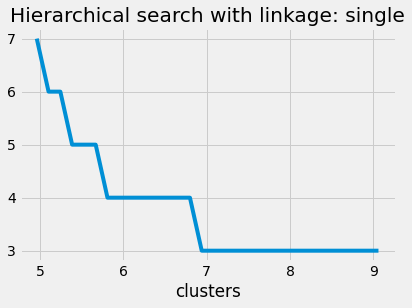

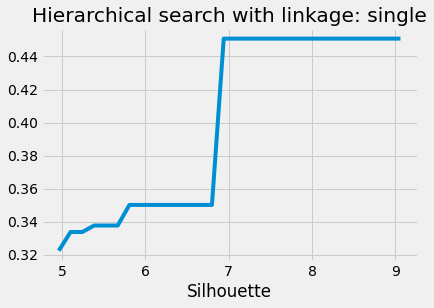

In [60]:
full_hierarchical_search(X_full)

____________ Plot for ward ____________


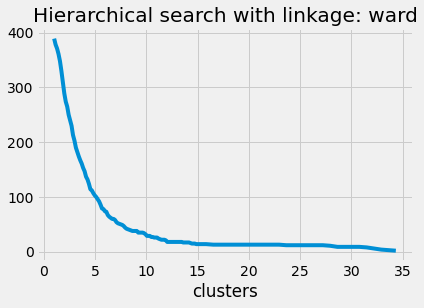

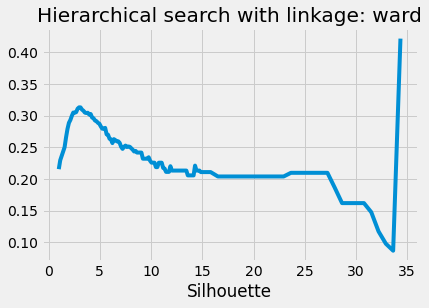

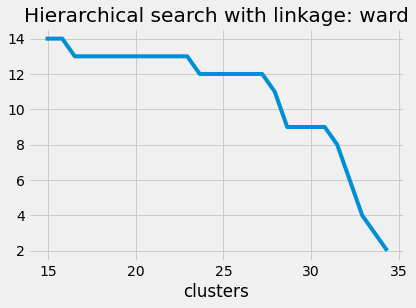

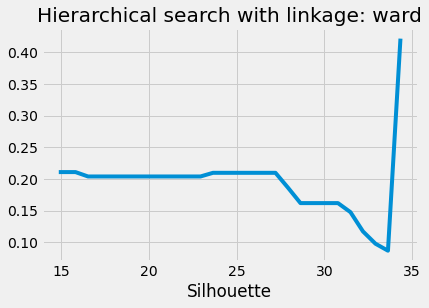

____________ Plot for average ____________


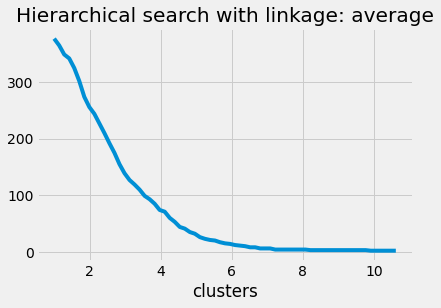

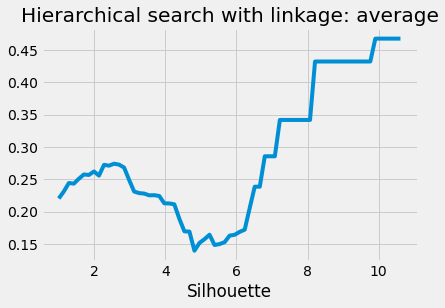

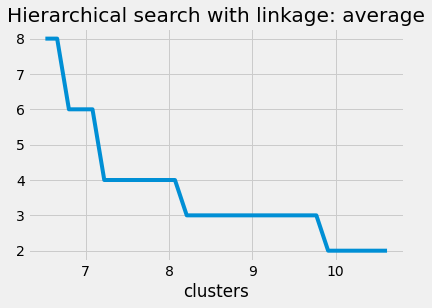

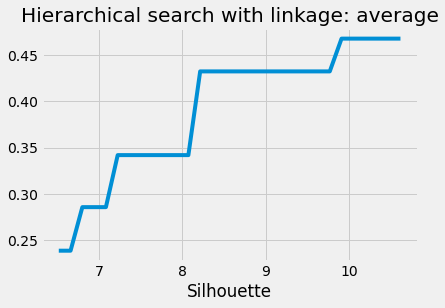

____________ Plot for complete ____________


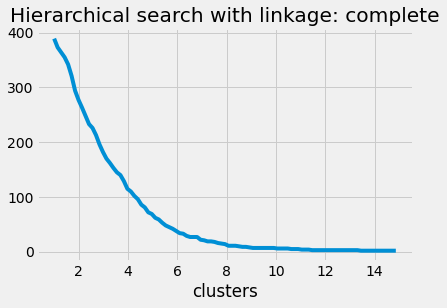

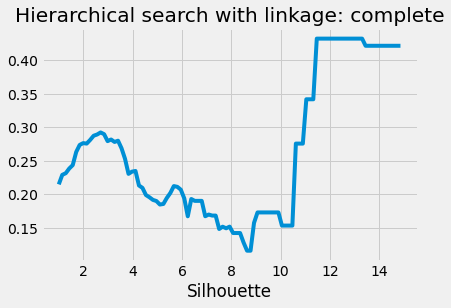

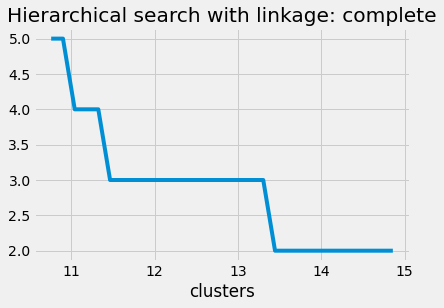

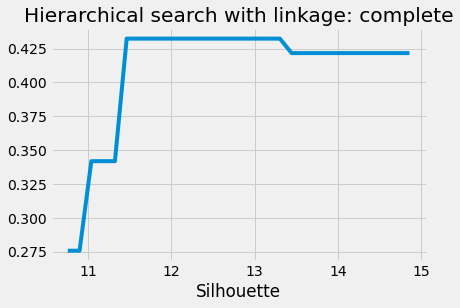

____________ Plot for single ____________


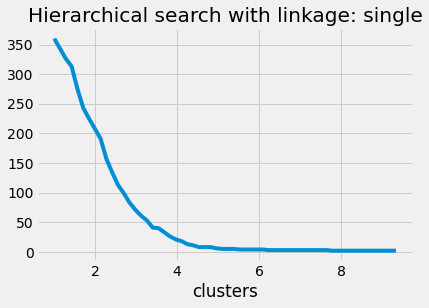

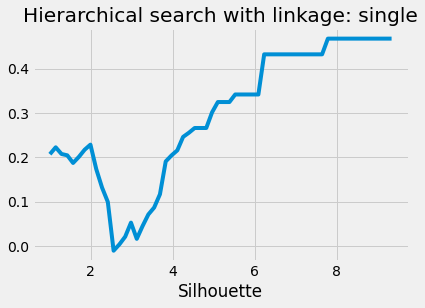

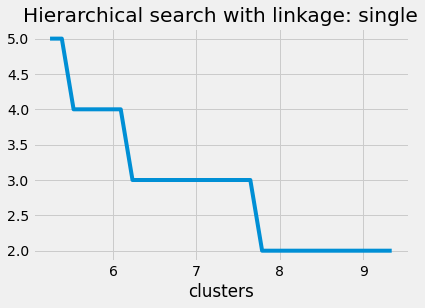

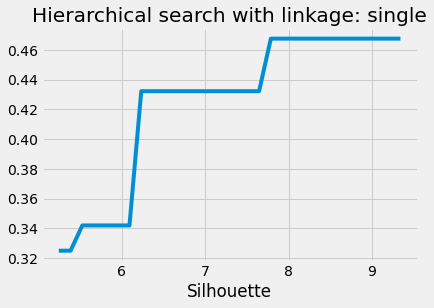

In [61]:
full_hierarchical_search(X_short)

# 2.3 DBSCAN

In [34]:
def use_dbscan(data):
    eps_range = np.linspace(0.1,10,100)
    output = []
    for epsilon in eps_range:
        db = DBSCAN(eps=epsilon, min_samples=7).fit(data)        
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        labels = db.labels_
        # print(labels)

        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)
        if n_clusters_<2:
            continue
        result = {
            "epsilon":epsilon,
            "clusters":n_clusters_,
            "noise_points": n_noise_,            
            "Silhouette": metrics.silhouette_score(data, labels)           
        }
        # print(result)
        output.append(result)
    return output

In [35]:
dbscan_full = use_dbscan(X_full)
df_dbscan_full = pd.DataFrame(dbscan_full)
df_dbscan_full = df_dbscan_full.set_index("epsilon")
print(df_dbscan_full.tail())

         clusters  noise_points  Silhouette
epsilon                                    
8.7             3             0    0.450806
8.8             3             0    0.450806
8.9             3             0    0.450806
9.0             3             0    0.450806
9.1             3             0    0.450806


In [36]:
dbscan_short = use_dbscan(X_short)
df_dbscan_short = pd.DataFrame(dbscan_short)
df_dbscan_short = df_dbscan_short.set_index("epsilon")
print(df_dbscan_short.tail())

         clusters  noise_points  Silhouette
epsilon                                    
7.2             2             6    0.432327
7.3             2             6    0.432327
7.4             2             6    0.432327
7.5             2             6    0.432327
7.6             2             6    0.432327


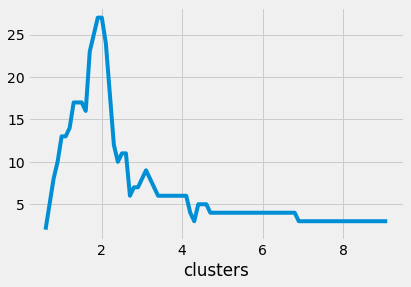

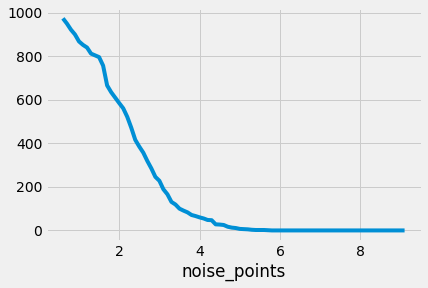

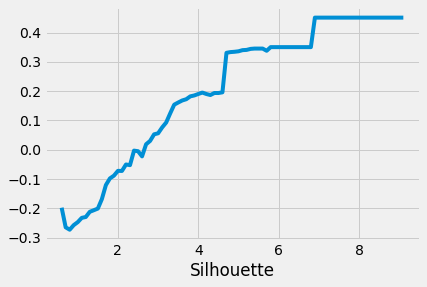

In [37]:
plot_df(df_dbscan_full)

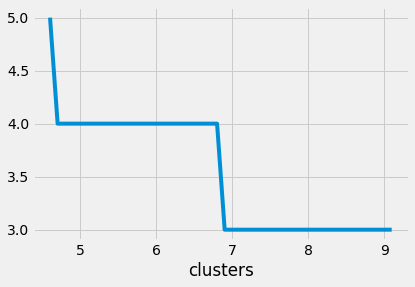

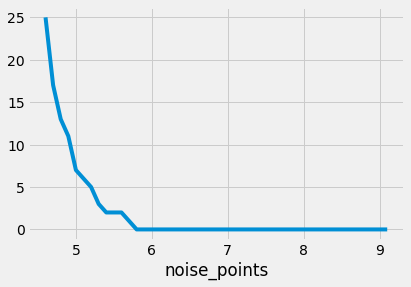

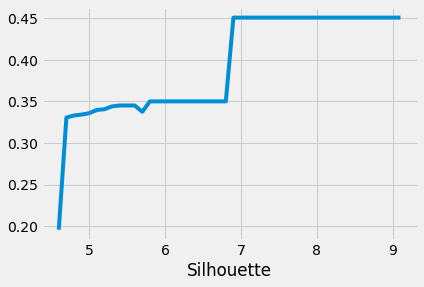

In [38]:
plot_df(df_dbscan_full.iloc[40:])

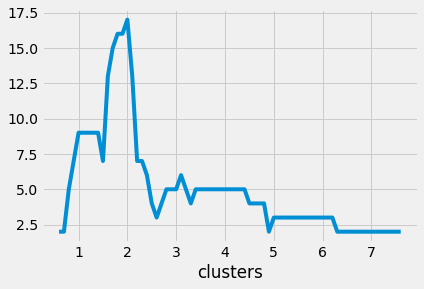

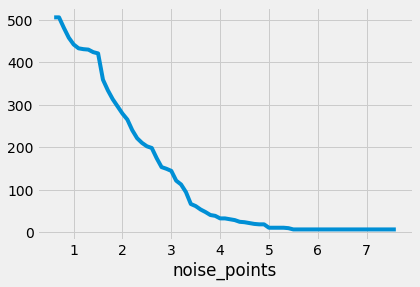

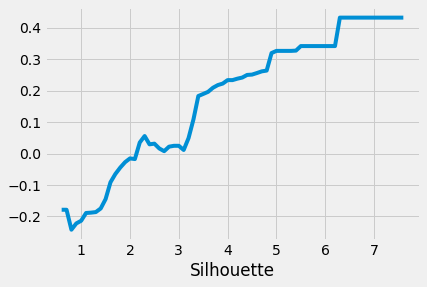

In [39]:
plot_df(df_dbscan_short)

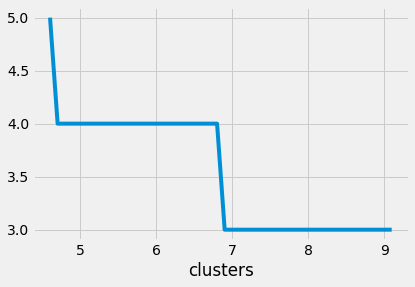

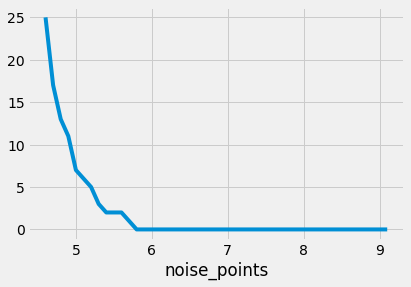

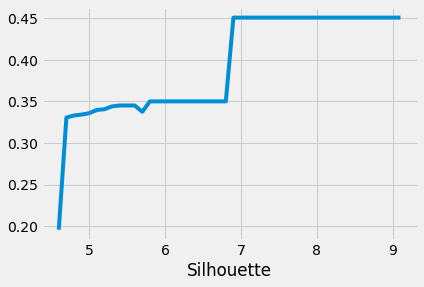

In [40]:
plot_df(df_dbscan_full.iloc[40:])

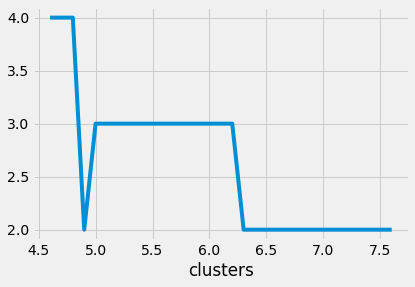

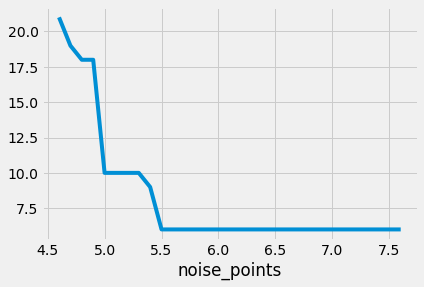

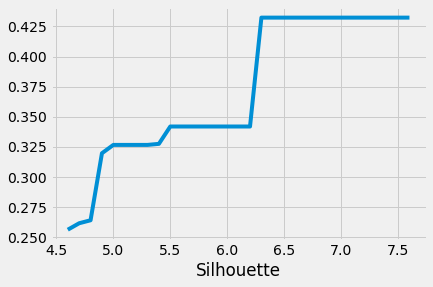

In [41]:
plot_df(df_dbscan_short.iloc[40:])

## 2.4 Заключение о числе кластеров 
Вычисленные значение силуэта для разных алгоритмов показывают, что 3 кластера это наилучшее число кластеров разбиения всего начального набора данных (data_full). Поэтому в дальнейшем будем рассматривать кластеризацию и свойства data_full_float - набора данных с OneHotEncoding и пометкой строк с отсутствующими данными как 'na'. 

# 3 Визуализация кластеризации

In [42]:
print(X_full.shape[1])

21


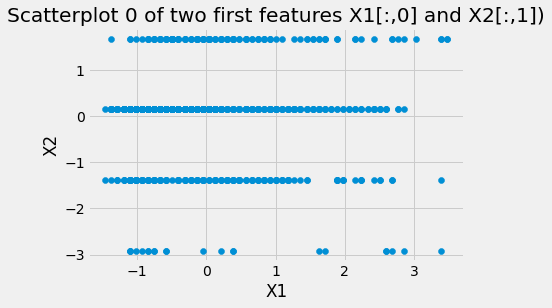

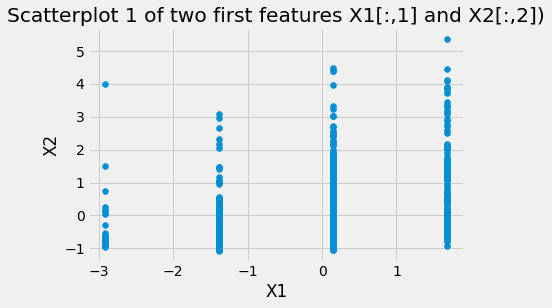

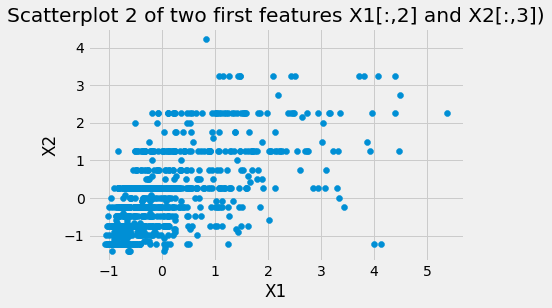

In [43]:
# plt.figure(figsize=(14, 6))

for i in range(min(3,(X_full.shape[1]-1))):
    plt.scatter(X_full[:,i], X_full[:,i+1]) #,c=y, s=20, cmap='coolwarm')
    plt.title(f'Scatterplot {i} of two first features X1[:,{i}] and X2[:,{i+1}])')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()

In [44]:
def plot_labeled_data(X,labels,tr_method,cl_method):
    plt.scatter(X[:,0], X[:,1],c=labels, s=20)#, cmap='coolwarm')
    plt.title(f'{tr_method} with {len(set(labels))} clusters from {cl_method}')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()

In [45]:
def plot_pca_with_labels(data,labels,name):
    pca = PCA(n_components=2)
    pca.fit(data)
    X_pca = pca.transform(data)    
    plot_labeled_data(X_pca, labels,"PCA", name)

In [46]:
# TSNE(n_components=3, learning_rate=rate, init='random',random_state = 3072).fit_transform(X_full)
def plot_tsne_with_labels(data,labels,name):
    X_tsne = TSNE(n_components=2, learning_rate='auto', init='random',random_state = 3072).fit_transform(data)
    # X_tsne.fit(data)    
    plot_labeled_data(X_tsne, labels,"t-SNE", name)

In [47]:
def plot_2d_transformation(data, threshold=7, clusters=2):
    # threshold = 7
    l_kmeans = KMeans(n_clusters=clusters, init='k-means++').fit(data).labels_    
    l_hierarchy = AgglomerativeClustering(linkage="average", n_clusters=clusters).fit_predict(data)
    l_dbscan = DBSCAN(eps=threshold, min_samples=7).fit(data).labels_
    # l_hierarchy = AgglomerativeClustering(linkage="average", distance_threshold = threshold, n_clusters=clusters).fit_predict(data)
    X_tsne = TSNE(n_components=2, learning_rate='auto', init='random',random_state = 3072).fit_transform(data)
    X_pca = PCA(n_components=2).fit_transform(data)
    X_umap = umap.UMAP().fit_transform(data)
    
    labels = {
        "KMeans":l_kmeans,
        "Hierarchy":l_hierarchy,
        "DBSCAN":l_dbscan
        }
    for cl_method in labels:
        plot_labeled_data(X_pca, labels[cl_method],"PCA", cl_method)
        plot_labeled_data(X_tsne, labels[cl_method],"t-SNE", cl_method)
        plot_labeled_data(X_umap, labels[cl_method],"UMAP", cl_method)
        # plot_pca_with_labels(data,labels[cl_method], cl_method)
        # plot_tsne_with_labels(data,labels[cl_method], cl_method)
        
    # plot_pca_with_labels(data,l_kmeans, "KMeans")
    # plot_pca_with_labels(data,l_hierarchy, "Hierarchy")
    # plot_pca_with_labels(data,l_dbscan, "DBSCAN")
    return {"labels_kmean":l_kmeans,
            "labels_hierarchy":l_hierarchy,
            "labels_dbscan": l_dbscan}
    

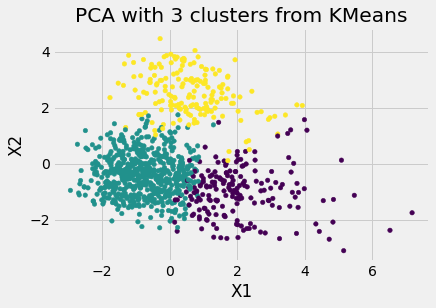

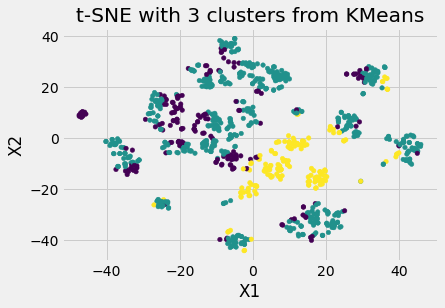

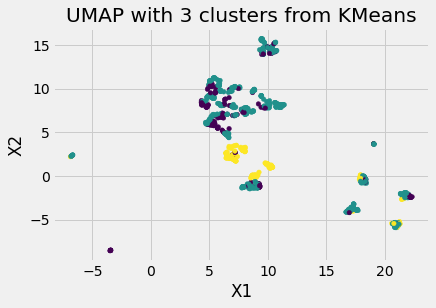

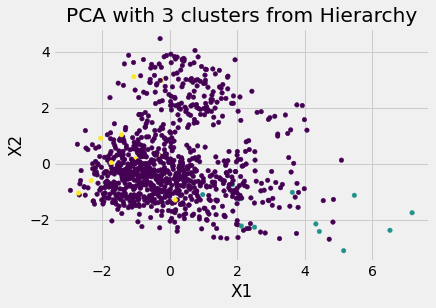

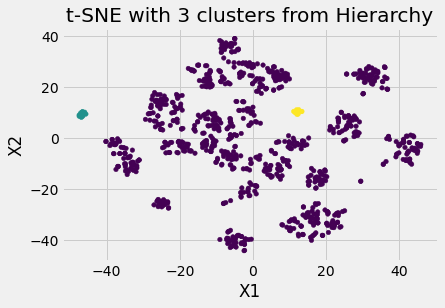

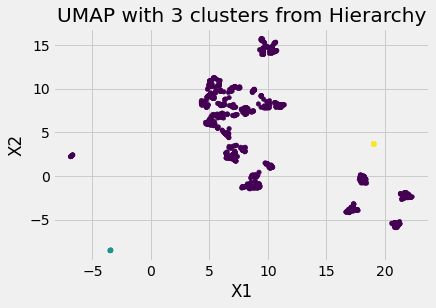

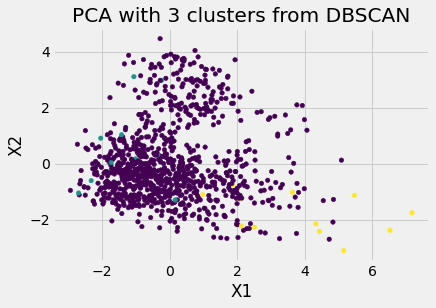

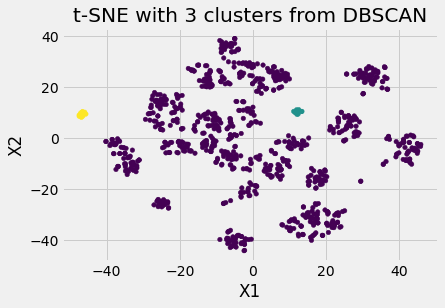

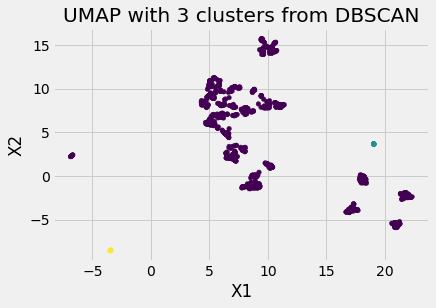

In [48]:
labels_full = plot_2d_transformation(X_full, threshold=7, clusters=3)

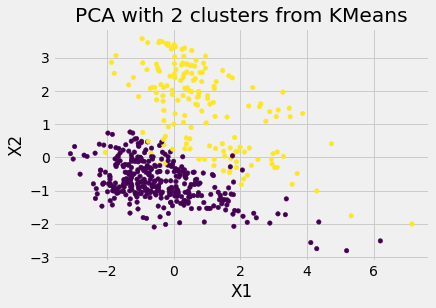

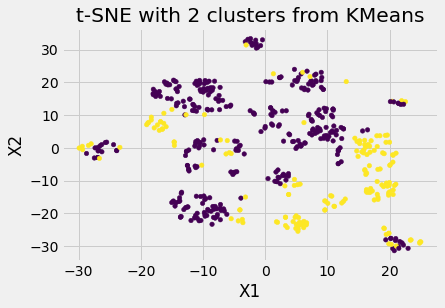

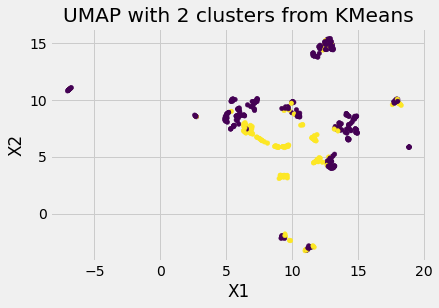

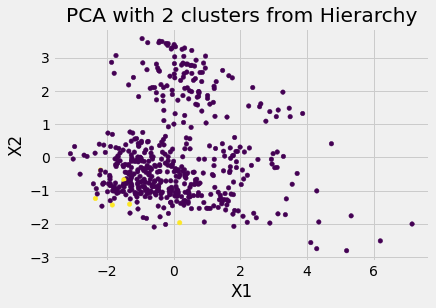

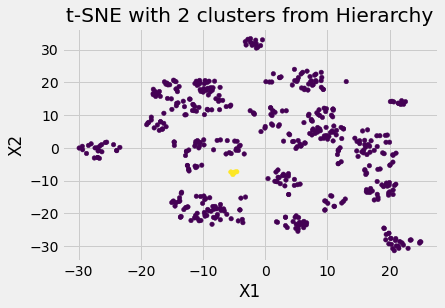

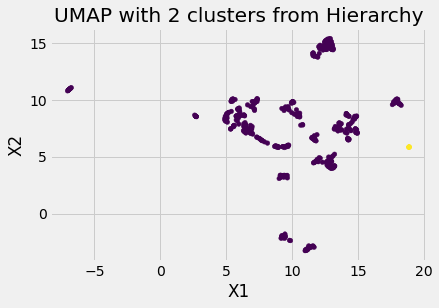

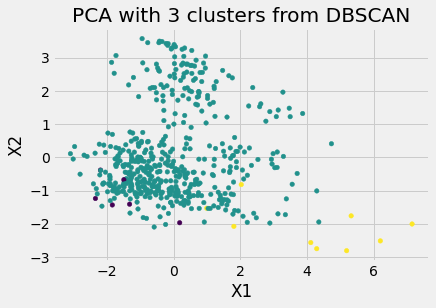

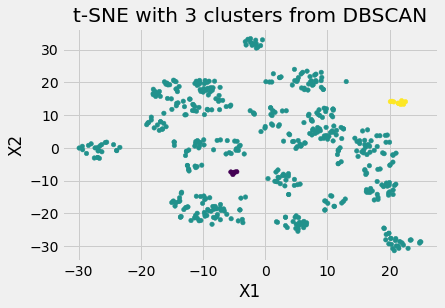

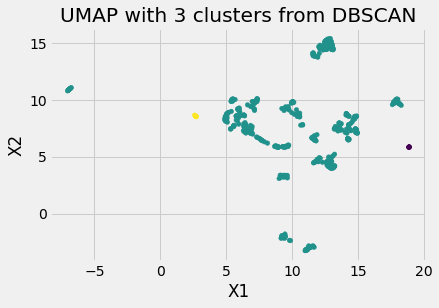

In [49]:
labels_short = plot_2d_transformation(X_short, threshold=7, clusters=2)

# 4 Интерпретация результатов


 - Теперь задача проинтерпретировать получившиеся кластеры. Начнем с простого расчета средних значений признаков для каждого из кластеров, есть ли интересные закономерности?
 - Теперь постройте boxplot-ы для каждого признака, сгруппировав значения по кластерам, по каким признакам заметно наибольшее отличие кластеров друг от друга? Можно ли их интерпретировать?

In [50]:
data_full.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,na,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,na,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car


In [51]:
test_data = data_full_floats.copy()

In [52]:
for item in labels_full:
    # print(f"item: {item} values = {labels_full[item][:5]}")
    test_data[item] = labels_full[item]
    

In [53]:
test_data.head()

,Age,Job,Credit amount,Duration,Sex_male,Housing_own,Housing_rent,Saving accounts_moderate,Saving accounts_na,Saving accounts_quite rich,...,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,labels_kmean,labels_hierarchy,labels_dbscan
0,67,2,1169,6,1,1,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
1,22,2,5951,48,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,49,1,2096,12,1,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
3,45,2,7882,42,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,53,2,4870,24,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


## 4.1 Табличные средние и суммарные значения для каждого из трех кластеров (полного набора данных)

In [54]:
print(f" Находим средних значений признаков для каждого из кластеров ")
for item in labels_full:
    df = test_data.groupby(by=[item]).mean()
    df_t = df.T
    print(f'               -----------  {item}  -----------')    
    print(df_t)

 Находим средних значений признаков для каждого из кластеров 
               -----------  labels_kmean  -----------
labels_kmean                           0            1            2
Age                            37.201058    36.515674    30.161850
Job                             2.306878     1.804075     1.832370
Credit amount                7335.132275  2177.343260  2865.739884
Duration                       36.814815    16.882445    18.346821
Sex_male                        0.835979     0.711599     0.450867
Housing_own                     0.656085     0.923197     0.000000
Housing_rent                    0.031746     0.000000     1.000000
Saving accounts_moderate        0.116402     0.094044     0.121387
Saving accounts_na              0.264550     0.161442     0.173410
Saving accounts_quite rich      0.015873     0.075235     0.069364
Saving accounts_rich            0.015873     0.056426     0.052023
Checking account_moderate       0.423280     0.227273     0.254335
Checking acco

In [55]:
print(f" Находим средних значений признаков для каждого из кластеров ")
for item in labels_full:
    df = test_data.groupby(by=[item]).sum()
    df_t = df.T
    print(f'               -----------  {item}  -----------')    
    print(df_t)

 Находим средних значений признаков для каждого из кластеров 
               -----------  labels_kmean  -----------
labels_kmean                         0          1         2
Age                             7031.0    23297.0    5218.0
Job                              436.0     1151.0     317.0
Credit amount                1386340.0  1389145.0  495773.0
Duration                        6958.0    10771.0    3174.0
Sex_male                         158.0      454.0      78.0
Housing_own                      124.0      589.0       0.0
Housing_rent                       6.0        0.0     173.0
Saving accounts_moderate          22.0       60.0      21.0
Saving accounts_na                50.0      103.0      30.0
Saving accounts_quite rich         3.0       48.0      12.0
Saving accounts_rich               3.0       36.0       9.0
Checking account_moderate         80.0      145.0      44.0
Checking account_na               50.0      286.0      58.0
Checking account_rich              2.0      

## 4.2 Boxplot-ы к ключевым 4 численным признакам для каждого из трех кластеров (полного набора данных):

Построение всех признаков возможно с помощью функции plot_one_label_value_all_cols, но трудно читаемо. Для анализа всех признаком проще смотреть вывод суммы и средних табличных значений с группировкой по кластерам.

In [56]:
def plot_one_label_value_all_cols(data,label, value):
    print(f"\nFor label={label} and value={value} boxplots looks like:")
    for ind in range(7):
        plt.figure(figsize=(10, 2))
        # plt.figure(figsize=(8, 3))
        for i,col in enumerate(cols[ind*3:(ind+1)*3]):
            plt.subplot(1, 3, i+1)
            sns.boxplot(x = data[data[label]==value][col]);
            # data[data[label]==value].boxplot(column=col)
        plt.show()

In [57]:
def plot_one_label_value_4_cols(data,label,col,max_val):
    print(f"\nFor label={label} and column={col} boxplots looks like:")    
    plt.figure(figsize=(3*max_val, 3))
        # plt.figure(figsize=(8, 3))
    for val in range(max_val):
        plt.subplot(1, max_val, val+1)
        # sns.boxplot(x = data[data[label]==value][col]);
        data[data[label]==val].boxplot(column=col)
        # data[data[label]==value].boxplot(column=col)
    plt.show()

 
 		-------===============----------


For label=labels_kmean and column=Age boxplots looks like:


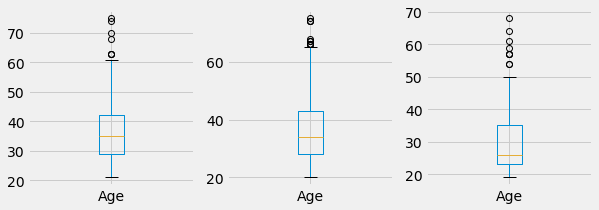


For label=labels_kmean and column=Job boxplots looks like:


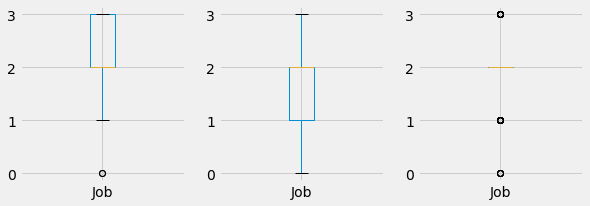


For label=labels_kmean and column=Credit amount boxplots looks like:


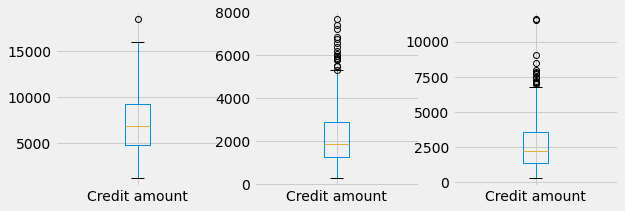


For label=labels_kmean and column=Duration boxplots looks like:


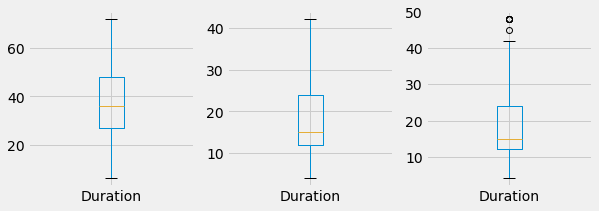

 
 		-------===============----------


For label=labels_hierarchy and column=Age boxplots looks like:


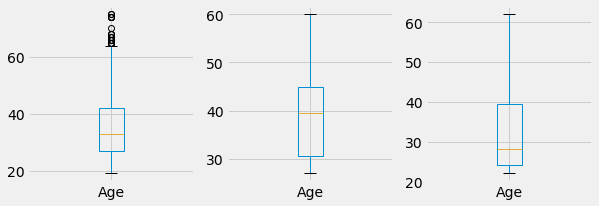


For label=labels_hierarchy and column=Job boxplots looks like:


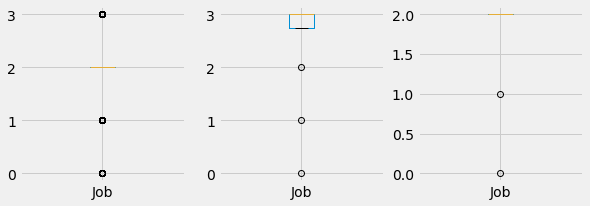


For label=labels_hierarchy and column=Credit amount boxplots looks like:


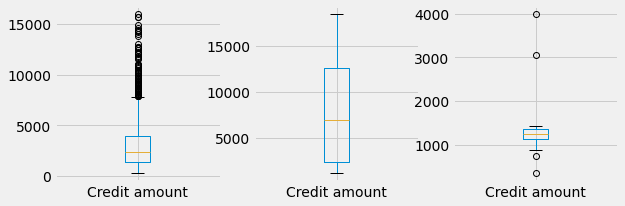


For label=labels_hierarchy and column=Duration boxplots looks like:


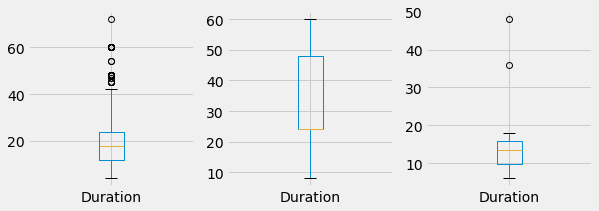

 
 		-------===============----------


For label=labels_dbscan and column=Age boxplots looks like:


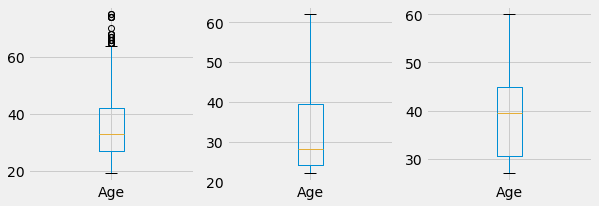


For label=labels_dbscan and column=Job boxplots looks like:


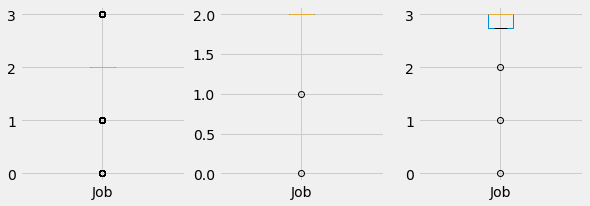


For label=labels_dbscan and column=Credit amount boxplots looks like:


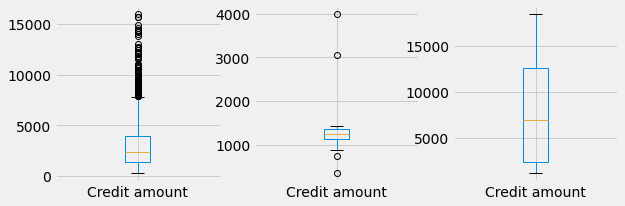


For label=labels_dbscan and column=Duration boxplots looks like:


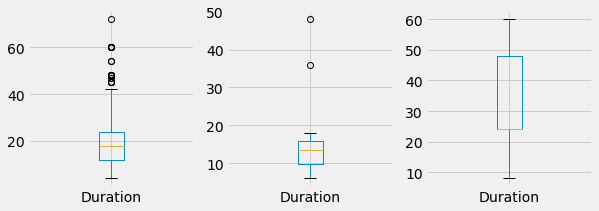

In [58]:
cols = test_data.columns[:-3]
n_clusters  = 3 #number of clusters 
for m_labels in labels_full:
    print(" \n \t\t-------===============----------\n")
    # for val in list(set(test_data[m_labels])):
    for col in cols[:4]:
        plot_one_label_value_4_cols(test_data,m_labels,col, n_clusters)
        # plot_one_label_value_4_cols(test_data,m_labels, val)
        # plot_one_label_value_all_cols(test_data,m_labels, val)
        

## 4.3 Результаты исследования кластеров

### Результаты исследования boxplot-ов и статистики (для численных переменных) показывают, что

Для кластеров(labels) полученных методом KMean:
- label  0: наименьший средний возраст  
- label  1: средние значения показателей 
- label  2: самая высокая средняя длительность кредита, наибольшее среднее объем кредита (Credit amount)

Для кластеров(labels) полученных иерархическим методом:
- label  0: средние значения показателей
- label  1: Наибольший возраст (Age), наивысший индекс работы (job), наибольшее среднее значение кредита (Credit amount)
- label  2: наименьшей средний объем кредита (Credit amount), наименьшее среднее время возврата время (Duration)

Для кластеров(labels) полученных методом DBSCAN. Получается такое же разбиение как и в иерархическом методе, только кластеры 1 и 2 поменялись местами:

- label  0: средние значения показателей
- label  1: наименьшей средний объем кредита (Credit amount), наименьшее среднее время возврата время (Duration)
- label  2: Наибольший возраст (Age), наивысший индекс работы (job), наибольшее среднее значение кредита (Credit amount)

### Результаты исследования статистики (для булевых переменных) показывают, что
Для кластеров(labels) полученных методом KMean:
- label  0: Те кто брал кредит только на мебель/оборудование (furniture/equipment), так как Purpose_car = Purpose_domestic appliances = Purpose_education = Purpose_radio/TV = Purpose_repairs = Purpose_vacation/others = 0 + Purpose_furniture/equipment = 180 больше всех остальных кластеров
- label  1: Владельцы жилья (и не снимают жилье) и кредит не на ремонт мебели/оборудования. Purpose_furniture/equipment = 0, Housing_rent =0, Housing_own =1
- label  2: В большинстве те кто снимает жилье и не владеет жильем, так как  Housing_rent - самое большое значение = 132  и самое маленькое Housing_own = 4 - в остальном все значения средние 

Для кластеров(labels) полученных иерархическим методом:
- label  0 кредит на машину, education, furniture/equipment,radio/TV,repairs  Saving accounts_rich + почти все Checking account_rich
- label  1 кредит на отпуск(другое) vacation/others
- label  2 кредит на домашнюю технику на domestic appliances

Для кластеров(labels) полученных методом DBSCAN получается такое же разбиение как и в иерархическом методе, только кластеры 1 и 2 поменялись местами:

- label  0 кредит на car, education, furniture/equipment,radio/TV,repairs  Saving accounts_rich + почти все Checking account_rich
- label  1 кредит на domestic appliances
- label  2 кредит на vacation/others 